<a href="https://colab.research.google.com/github/SBShimm/Datathon/blob/main/Visual_Flix_jumi_0727pm8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1242]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 가져오기
#### 1) 데이터 종류

In [1243]:
file_dir = '/content/drive/MyDrive/dataton/Folder/Datathon/Dataset/Netflix_IMDB.csv'
# file_dir = '/content/drive/MyDrive/Visual_Flix/Netflix_IMDB.csv'

data = pd.read_csv(file_dir)

In [1244]:
data.head()

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",7.4
1,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",6.3
2,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,NaN
3,3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",NaN
4,4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,NaN


In [1245]:
data.isnull().sum()

Unnamed: 0         0
show_id            0
type               0
title              0
director        2659
cast             828
country          844
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
IMDB            3555
dtype: int64

In [1246]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8877 entries, 0 to 8876
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    8877 non-null   int64  
 1   show_id       8877 non-null   object 
 2   type          8877 non-null   object 
 3   title         8877 non-null   object 
 4   director      6218 non-null   object 
 5   cast          8049 non-null   object 
 6   country       8033 non-null   object 
 7   date_added    8867 non-null   object 
 8   release_year  8877 non-null   int64  
 9   rating        8873 non-null   object 
 10  duration      8874 non-null   object 
 11  listed_in     8877 non-null   object 
 12  description   8877 non-null   object 
 13  IMDB          5322 non-null   float64
dtypes: float64(1), int64(2), object(11)
memory usage: 971.0+ KB


# 2. Data 전처리

#### 1)Data 추출

In [1247]:
data['date_added'] = pd.to_datetime(data['date_added'])

In [1248]:
# datetime 타입에서 년, 월, 일 추출
data['year'] = data.date_added.apply(lambda x : x.year)
data['month'] = data.date_added.apply(lambda x : x.month)
data['day'] = data.date_added.apply(lambda x : x.day)

#년월일 int로 변경
data['year'] = pd.to_datetime(data['year']).astype(np.int64)
data['month'] = pd.to_datetime(data['month']).astype(np.int64)
data['day'] = pd.to_datetime(data['day']).astype(np.int64)

data.head(3)

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB,year,month,day
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",7.4,2021,9,25
1,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",6.3,2021,9,24
2,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,NaN,2021,9,24


In [1249]:
data.drop(data.loc[data['year']<0].index, inplace=True)

#### 2) Type 나누기, 장르세분화

In [1250]:
def genere(what):
    if what == 'all':
        genere = data.listed_in.value_counts()
    else:
        genere = data[data['type'] == what].listed_in.value_counts()
    gener = {}
    
    for idx, val in genere.items():
        l = idx.split(',')
        for i in l:
            i = i.strip()
            if i in gener.keys():
                d = {}
                d[i] = val + gener[i]
                gener.update(d)
            else:
                d = {i:val}
                gener.update(d)
    theme, count = [],[]
    
    for idx, val in gener.items():
        theme.append(idx)
        count.append(val)
    
    list_temp = (pd.DataFrame({'genere':theme, 'count': count})
        .sort_values('count', ascending = True))
    list_temp.reset_index(drop = True, inplace = True)
    
    return list_temp

In [1251]:
tv_genere = genere('TV Show')
tv_genere

,genere,count
0,TV Shows,16
1,Classic & Cult TV,26
2,Stand-Up Comedy & Talk Shows,56
3,TV Thrillers,59
4,Teen TV Shows,69
5,TV Horror,76
6,TV Sci-Fi & Fantasy,84
7,Science & Nature TV,92
8,TV Mysteries,101
9,Korean TV Shows,155


In [1252]:
mov_genere = genere('Movie')
mov_genere

,genere,count
0,Movies,58
1,Faith & Spirituality,66
2,Cult Movies,71
3,Anime Features,71
4,LGBTQ Movies,103
5,Classic Movies,116
6,Sports Movies,220
7,Sci-Fi & Fantasy,245
8,Stand-Up Comedy,343
9,Horror Movies,358


#### 3)Country data 전처리

In [1253]:
data['first_country'] = data.country.str.extract(r'([a-zA-Z\s]+)')

In [1254]:
data.head()

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB,year,month,day,first_country
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",7.4,2021,9,25,United States
1,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",6.3,2021,9,24,South Africa
2,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,NaN,2021,9,24,NaN
3,3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",NaN,2021,9,24,NaN
4,4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,NaN,2021,9,24,India


#### 4) 별점 data (내림차순)

In [1255]:
df_rating = data.sort_values(by = 'IMDB',ascending=False)
df_rating.head()

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB,year,month,day,first_country
6010,6010,s5941,TV Show,Breaking Bad,NaN,"Bryan Cranston, Aaron Paul, Anna Gunn, Dean No...",United States,2013-08-02,2013,TV-MA,5 Seasons,"Crime TV Shows, TV Dramas, TV Thrillers",A high school chemistry teacher dying of cance...,9.4,2013,8,2,United States
2558,2558,s2520,TV Show,Avatar: The Last Airbender,NaN,"Zach Tyler, Mae Whitman, Jack De Sena, Dee Bra...",United States,2020-05-15,2007,TV-Y7,3 Seasons,"Classic & Cult TV, Kids' TV, TV Action & Adven...",Siblings Katara and Sokka wake young Aang from...,9.3,2020,5,15,United States
3119,3119,s3072,TV Show,Reply 1988,NaN,"Lee Hye-ri, Park Bo-gum, Ryu Jun-yeol, Ko Kyou...",South Korea,2020-01-01,2015,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",Take a nostalgic trip back to the late 1980s t...,9.2,2020,1,1,South Korea
688,688,s681,TV Show,The Last Dance,NaN,"Michael Jordan, Scottie Pippen, Dennis Rodman",United States,2021-06-19,2020,TV-MA,1 Season,Docuseries,This docuseries gives a definitive account of ...,9.2,2021,6,19,United States
3995,3995,s3939,TV Show,Our Planet,NaN,David Attenborough,"United States, United Kingdom",2019-04-05,2019,TV-PG,1 Season,"Docuseries, Science & Nature TV",Experience our planet's natural beauty and exa...,9.2,2019,4,5,United States


시각화


장르별 별점

In [1256]:
df_temp = df_rating[['show_id','type','listed_in','IMDB']]
df_temp

,show_id,type,listed_in,IMDB
6010,s5941,TV Show,"Crime TV Shows, TV Dramas, TV Thrillers",9.4
2558,s2520,TV Show,"Classic & Cult TV, Kids' TV, TV Action & Adven...",9.3
3119,s3072,TV Show,"International TV Shows, Korean TV Shows, Roman...",9.2
688,s681,TV Show,Docuseries,9.2
3995,s3939,TV Show,"Docuseries, Science & Nature TV",9.2
...,...,...,...,...
8871,s8802,Movie,"Dramas, International Movies, Thrillers",NaN
8872,s8803,Movie,"Cult Movies, Dramas, Thrillers",NaN
8873,s8804,TV Show,"Kids' TV, Korean TV Shows, TV Comedies",NaN
8875,s8806,Movie,"Children & Family Movies, Comedies",NaN


In [1257]:
def genere(what):
    if what == 'all':
        genere = df_temp.listed_in.value_counts()
    else:
        genere = df_temp[df_temp['type'] == what].listed_in.value_counts()
    gener = {}
    
    for idx, val in genere.items():
        l = idx.split(',')
        for i in l:
            i = i.strip()
            if i in gener.keys():
                d = {}
                d[i] = val + gener[i]
                gener.update(d)
            else:
                d = {i:val}
                gener.update(d)
    theme, count = [],[]
    
    for idx, val in gener.items():
        theme.append(idx)
        count.append(val)
       
    
    list_temp = (pd.DataFrame({'genere':theme, 'count': count})
        .sort_values('count', ascending = True))
    list_temp.reset_index(drop = True, inplace = True)
    
    return list_temp

In [1258]:
tv = genere('TV Show')
tv

,genere,count
0,TV Shows,16
1,Classic & Cult TV,26
2,Stand-Up Comedy & Talk Shows,56
3,TV Thrillers,59
4,Teen TV Shows,69
5,TV Horror,76
6,TV Sci-Fi & Fantasy,84
7,Science & Nature TV,92
8,TV Mysteries,101
9,Korean TV Shows,155


In [1259]:
mov = genere('Movie')
mov

,genere,count
0,Movies,58
1,Faith & Spirituality,66
2,Cult Movies,71
3,Anime Features,71
4,LGBTQ Movies,103
5,Classic Movies,116
6,Sports Movies,220
7,Sci-Fi & Fantasy,245
8,Stand-Up Comedy,343
9,Horror Movies,358


In [1316]:
df_temp['IMDB_band']=0
df_temp.loc[df_temp['IMDB']<=1, 'IMDB_band']=1
df_temp.loc[(df_temp['IMDB']>1)&(df_temp['IMDB']<=2),'IMDB_band']=2
df_temp.loc[(df_temp['IMDB']>2)&(df_temp['IMDB']<=3),'IMDB_band']=3
df_temp.loc[(df_temp['IMDB']>3)&(df_temp['IMDB']<=4),'IMDB_band']=4
df_temp.loc[(df_temp['IMDB']>4)&(df_temp['IMDB']<=5),'IMDB_band']=5
df_temp.loc[(df_temp['IMDB']>5)&(df_temp['IMDB']<=6),'IMDB_band']=6
df_temp.loc[(df_temp['IMDB']>6)&(df_temp['IMDB']<=7),'IMDB_band']=7
df_temp.loc[(df_temp['IMDB']>7)&(df_temp['IMDB']<=8),'IMDB_band']=8
df_temp.loc[(df_temp['IMDB']>8)&(df_temp['IMDB']<=9),'IMDB_band']=9
df_temp.loc[df_temp['IMDB']>9,'IMDB_band']=10
df_rating['IMDB_band'] = df_temp['IMDB_band']
df_rating

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB,year,month,day,first_country,IMDB_band
6010,6010,s5941,TV Show,Breaking Bad,NaN,"Bryan Cranston, Aaron Paul, Anna Gunn, Dean No...",United States,2013-08-02,2013,TV-MA,5 Seasons,"Crime TV Shows, TV Dramas, TV Thrillers",A high school chemistry teacher dying of cance...,9.4,2013,8,2,United States,10
2558,2558,s2520,TV Show,Avatar: The Last Airbender,NaN,"Zach Tyler, Mae Whitman, Jack De Sena, Dee Bra...",United States,2020-05-15,2007,TV-Y7,3 Seasons,"Classic & Cult TV, Kids' TV, TV Action & Adven...",Siblings Katara and Sokka wake young Aang from...,9.3,2020,5,15,United States,10
3119,3119,s3072,TV Show,Reply 1988,NaN,"Lee Hye-ri, Park Bo-gum, Ryu Jun-yeol, Ko Kyou...",South Korea,2020-01-01,2015,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",Take a nostalgic trip back to the late 1980s t...,9.2,2020,1,1,South Korea,10
688,688,s681,TV Show,The Last Dance,NaN,"Michael Jordan, Scottie Pippen, Dennis Rodman",United States,2021-06-19,2020,TV-MA,1 Season,Docuseries,This docuseries gives a definitive account of ...,9.2,2021,6,19,United States,10
3995,3995,s3939,TV Show,Our Planet,NaN,David Attenborough,"United States, United Kingdom",2019-04-05,2019,TV-PG,1 Season,"Docuseries, Science & Nature TV",Experience our planet's natural beauty and exa...,9.2,2019,4,5,United States,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8871,8871,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan",2016-03-09,2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...,NaN,2016,3,9,United Arab Emirates,0
8872,8872,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",NaN,2019,11,20,United States,0
8873,8873,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,2019-07-01,2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",NaN,2019,7,1,NaN,0
8875,8875,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",NaN,2020,1,11,United States,0


tv_show, movie 분리


In [1261]:
df_movie = df_temp[df_temp['type'] == 'Movie']
df_movie

,show_id,type,listed_in,IMDB,IMDB_band
1915,s1887,Movie,Documentaries,9.1,10
836,s827,Movie,Stand-Up Comedy,9.0,9
2526,s2488,Movie,"Comedies, Dramas, International Movies",9.0,9
917,s908,Movie,Documentaries,8.9,9
3583,s3532,Movie,"Comedies, Dramas, Independent Movies",8.9,9
...,...,...,...,...,...
8869,s8800,Movie,"Dramas, International Movies",NaN,0
8871,s8802,Movie,"Dramas, International Movies, Thrillers",NaN,0
8872,s8803,Movie,"Cult Movies, Dramas, Thrillers",NaN,0
8875,s8806,Movie,"Children & Family Movies, Comedies",NaN,0


In [1262]:
df_tv_show = df_temp[df_temp['type'] == 'TV Show']
df_tv_show

,show_id,type,listed_in,IMDB,IMDB_band
6010,s5941,TV Show,"Crime TV Shows, TV Dramas, TV Thrillers",9.4,10
2558,s2520,TV Show,"Classic & Cult TV, Kids' TV, TV Action & Adven...",9.3,10
3119,s3072,TV Show,"International TV Shows, Korean TV Shows, Roman...",9.2,10
688,s681,TV Show,Docuseries,9.2,10
3995,s3939,TV Show,"Docuseries, Science & Nature TV",9.2,10
...,...,...,...,...,...
8855,s8786,TV Show,Kids' TV,NaN,0
8865,s8796,TV Show,"Anime Series, Kids' TV",NaN,0
8867,s8798,TV Show,Kids' TV,NaN,0
8870,s8801,TV Show,"International TV Shows, Romantic TV Shows, TV ...",NaN,0


In [1263]:
#df_tv_show.loc[(df_tv_show['listed_in'].isin(['Science & Nature TV']))]
df_tv_show[df_tv_show['listed_in'].str.contains('Nature')]

,show_id,type,listed_in,IMDB,IMDB_band
3995,s3939,TV Show,"Docuseries, Science & Nature TV",9.2,10
5872,s5804,TV Show,"Crime TV Shows, Docuseries, Science & Nature TV",8.8,9
3592,s3541,TV Show,"Docuseries, Science & Nature TV",8.8,9
8615,s8546,TV Show,"Docuseries, Science & Nature TV",8.7,9
2444,s2407,TV Show,"Docuseries, Reality TV, Science & Nature TV",8.6,9
...,...,...,...,...,...
8541,s8472,TV Show,"Docuseries, Science & Nature TV",NaN,0
8674,s8605,TV Show,"British TV Shows, Docuseries, Science & Nature TV",NaN,0
8782,s8713,TV Show,"British TV Shows, Docuseries, Science & Nature TV",NaN,0
8810,s8741,TV Show,"British TV Shows, Docuseries, Science & Nature TV",NaN,0


In [1264]:
print(df_movie.isnull().sum())
print(df_tv_show.isnull().sum())

show_id         0
type            0
listed_in       0
IMDB         2653
IMDB_band       0
dtype: int64
show_id        0
type           0
listed_in      0
IMDB         892
IMDB_band      0
dtype: int64


In [1265]:
df_movie = df_movie.dropna(axis=0)
df_tv_show = df_tv_show.dropna(axis=0)

In [1266]:
df_movie_IMDB = df_movie.drop(['type','IMDB'], axis=1)
df_tv_show_IMDB = df_tv_show.drop(['type','IMDB'], axis=1)
df_movie_IMDB

,show_id,listed_in,IMDB_band
1915,s1887,Documentaries,10
836,s827,Stand-Up Comedy,9
2526,s2488,"Comedies, Dramas, International Movies",9
917,s908,Documentaries,9
3583,s3532,"Comedies, Dramas, Independent Movies",9
...,...,...,...
2663,s2625,"Comedies, International Movies",2
1120,s1107,Action & Adventure,2
4503,s4443,"Action & Adventure, Comedies, International Mo...",2
923,s914,"Dramas, International Movies, Romantic Movies",2


In [1267]:
df_tv_show_IMDB

,show_id,listed_in,IMDB_band
6010,s5941,"Crime TV Shows, TV Dramas, TV Thrillers",10
2558,s2520,"Classic & Cult TV, Kids' TV, TV Action & Adven...",10
3119,s3072,"International TV Shows, Korean TV Shows, Roman...",10
688,s681,Docuseries,10
3995,s3939,"Docuseries, Science & Nature TV",10
...,...,...,...
533,s531,"Kids' TV, TV Comedies",4
3088,s3041,"International TV Shows, Reality TV, TV Comedies",3
3041,s2994,Reality TV,3
6894,s6825,"International TV Shows, TV Comedies, TV Dramas",3


In [1268]:
def genere_2cols(df, col):
    
    genere_year = df[[col, 'listed_in']].value_counts()
    
    gener = {}
    
    for idx, val in genere_year.items():
        i_col = str(idx[0])
        l = idx[1].split(',')
        for i in l:
            genre_split = i.strip()
            key = i_col + ':' + genre_split
            if i in gener.keys():
                d = {}
                d[key] = val + gener[key]
                gener.update(d)
            else:
                d = {key:val}
                gener.update(d)
    cols, theme, count = [], [], []
    
    for idx, val in gener.items():
        cols.append((idx.split(':')[0]))
        theme.append(idx.split(':')[1])
        count.append(val)
    
    list_temp = (pd.DataFrame({col: cols, 'genre':theme, 'count': count})
        .sort_values('count', ascending = True))
    list_temp.reset_index(drop = True, inplace = True)
    
    return list_temp

tv_show 장르별 counting

In [1269]:
df_tv_show_IMDB = genere_2cols(df_tv_show_IMDB,'IMDB_band')
df_tv_show_IMDB

,IMDB_band,genre,count
0,7,Kids' TV,1
1,8,TV Shows,1
2,10,Science & Nature TV,1
3,10,Docuseries,1
4,10,TV Thrillers,1
...,...,...,...
135,6,Stand-Up Comedy & Talk Shows,1
136,10,TV Mysteries,1
137,5,Stand-Up Comedy & Talk Shows,2
138,9,TV Shows,2


In [1270]:
df_tv_show_IMDB.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IMDB_band  140 non-null    object
 1   genre      140 non-null    object
 2   count      140 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.4+ KB


In [1271]:
df_tv_show_IMDB = df_tv_show_IMDB.astype({'IMDB_band':'int'})

In [1272]:
df_tv_show_IMDB['genre'].value_counts()

International TV Shows          9
TV Dramas                       9
TV Comedies                     8
Kids' TV                        7
Reality TV                      7
TV Mysteries                    7
Romantic TV Shows               7
Crime TV Shows                  7
Docuseries                      7
Science & Nature TV             7
TV Action & Adventure           6
Korean TV Shows                 6
TV Thrillers                    6
TV Horror                       6
Stand-Up Comedy & Talk Shows    6
Spanish-Language TV Shows       6
British TV Shows                6
TV Sci-Fi & Fantasy             5
Teen TV Shows                   5
Anime Series                    5
Classic & Cult TV               4
TV Shows                        4
Name: genre, dtype: int64

In [1273]:
df_tv_show_IMDB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IMDB_band  140 non-null    int64 
 1   genre      140 non-null    object
 2   count      140 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ KB


장르로 그룹화해서 평점을 평균내야하는데 count값이 있어서 count를 곱해준다음에 평균내야함..

In [1274]:
df_tv_show_IMDB['total'] = (df_tv_show_IMDB['IMDB_band']*df_tv_show_IMDB['count'])
df_tv_show_IMDB

,IMDB_band,genre,count,total
0,7,Kids' TV,1,7
1,8,TV Shows,1,8
2,10,Science & Nature TV,1,10
3,10,Docuseries,1,10
4,10,TV Thrillers,1,10
...,...,...,...,...
135,6,Stand-Up Comedy & Talk Shows,1,6
136,10,TV Mysteries,1,10
137,5,Stand-Up Comedy & Talk Shows,2,10
138,9,TV Shows,2,18


In [1275]:
grouped_tv =df_tv_show_IMDB.groupby('genre')
grouped_tv = grouped_tv.mean().reset_index()
grouped_tv.drop(labels=['IMDB_band','count'],axis=1,inplace=True)
grouped_tv.columns = ['genre','mean']
grouped_tv
#df_tv_show_IMDB['mean'] = grouped['total']
#df_tv_show_IMDB

,genre,mean
0,Anime Series,7.000000
1,British TV Shows,6.500000
2,Classic & Cult TV,8.500000
3,Crime TV Shows,7.000000
4,Docuseries,7.000000
5,International TV Shows,6.000000
6,Kids' TV,8.142857
7,Korean TV Shows,7.500000
8,Reality TV,6.000000
9,Romantic TV Shows,7.000000


movie 장르별 counting

In [1276]:
df_movie_IMDB = genere_2cols(df_movie_IMDB,'IMDB_band')
df_movie_IMDB

,IMDB_band,genre,count
0,7,Stand-Up Comedy,1
1,9,Sports Movies,1
2,5,Sports Movies,1
3,3,Independent Movies,1
4,7,Cult Movies,1
...,...,...,...
128,9,Stand-Up Comedy,3
129,6,Movies,4
130,7,Movies,5
131,8,Movies,8


In [1277]:
df_movie_IMDB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IMDB_band  133 non-null    object
 1   genre      133 non-null    object
 2   count      133 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.2+ KB


IMDB_band가 object자료형이라 계산해주려면 int로 바꿔줘야 한다.

In [1278]:
df_movie_IMDB = df_movie_IMDB.astype({'IMDB_band':'int'})

장르로 그룹화해서 평점을 평균내야하는데 count값이 있어서 count를 곱해준다음에 평균내야함..

In [1279]:
df_movie_IMDB['total'] = (df_movie_IMDB['IMDB_band']*df_movie_IMDB['count'])
df_movie_IMDB

,IMDB_band,genre,count,total
0,7,Stand-Up Comedy,1,7
1,9,Sports Movies,1,9
2,5,Sports Movies,1,5
3,3,Independent Movies,1,3
4,7,Cult Movies,1,7
...,...,...,...,...
128,9,Stand-Up Comedy,3,27
129,6,Movies,4,24
130,7,Movies,5,35
131,8,Movies,8,64


In [1280]:
grouped_mov =df_movie_IMDB.groupby('genre')
grouped_mov = grouped_mov.mean().reset_index()
grouped_mov.drop(labels=['IMDB_band','count'],axis=1,inplace=True)
grouped_mov.columns = ['genre','mean']
grouped_mov


,genre,mean
0,Action & Adventure,5.500000
1,Anime Features,7.000000
2,Children & Family Movies,6.000000
3,Classic Movies,8.000000
4,Comedies,5.500000
5,Cult Movies,6.333333
6,Documentaries,6.500000
7,Dramas,5.500000
8,Faith & Spirituality,6.000000
9,Horror Movies,6.428571


Netflix Color Palette 생성

https://htmlcolors.com/color-mixer 사이트를 활용하여 넷플릭스 시그니처 컬러를 그라데이션 한 팔레트를 생성했습니다.

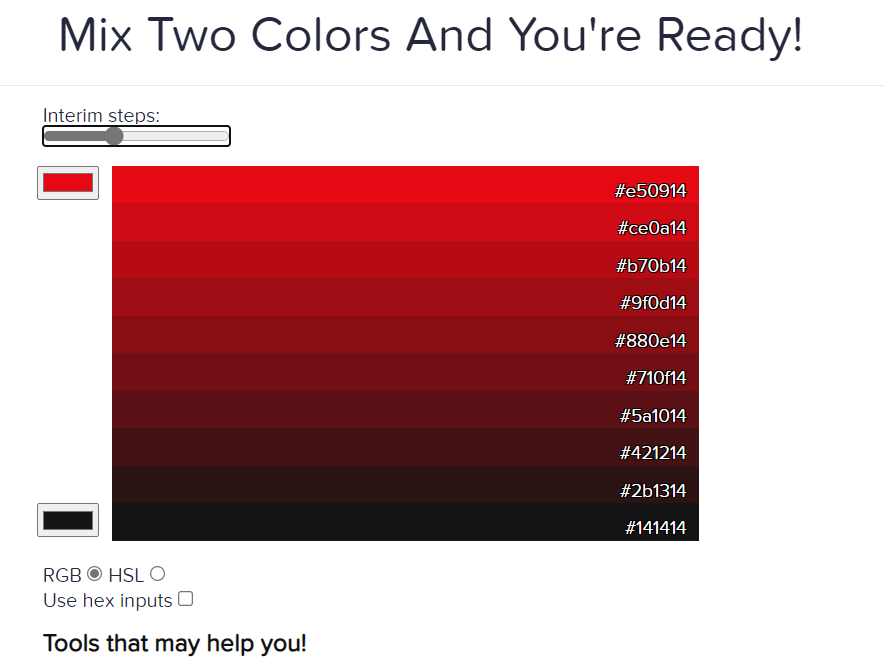

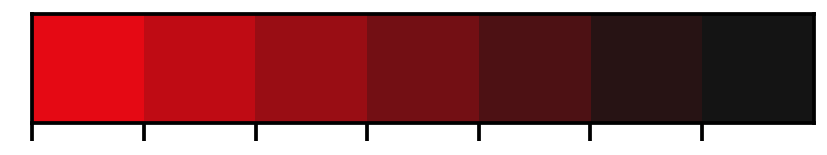

In [1281]:
grad = ["#e50914", "#bf0b14", "#990d14","#730f14","#4d1114" , "#271314","#141414"]
sns.palplot(sns.color_palette(grad))
sns.set_palette(sns.color_palette(grad))

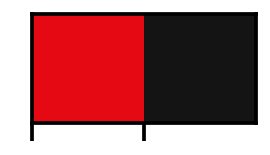

In [1282]:
colors = ["#E50914", "#141414"]
sns.palplot(sns.color_palette(colors))
sns.set_palette(sns.color_palette(colors))

장르별 평균 평점 BEST 5 

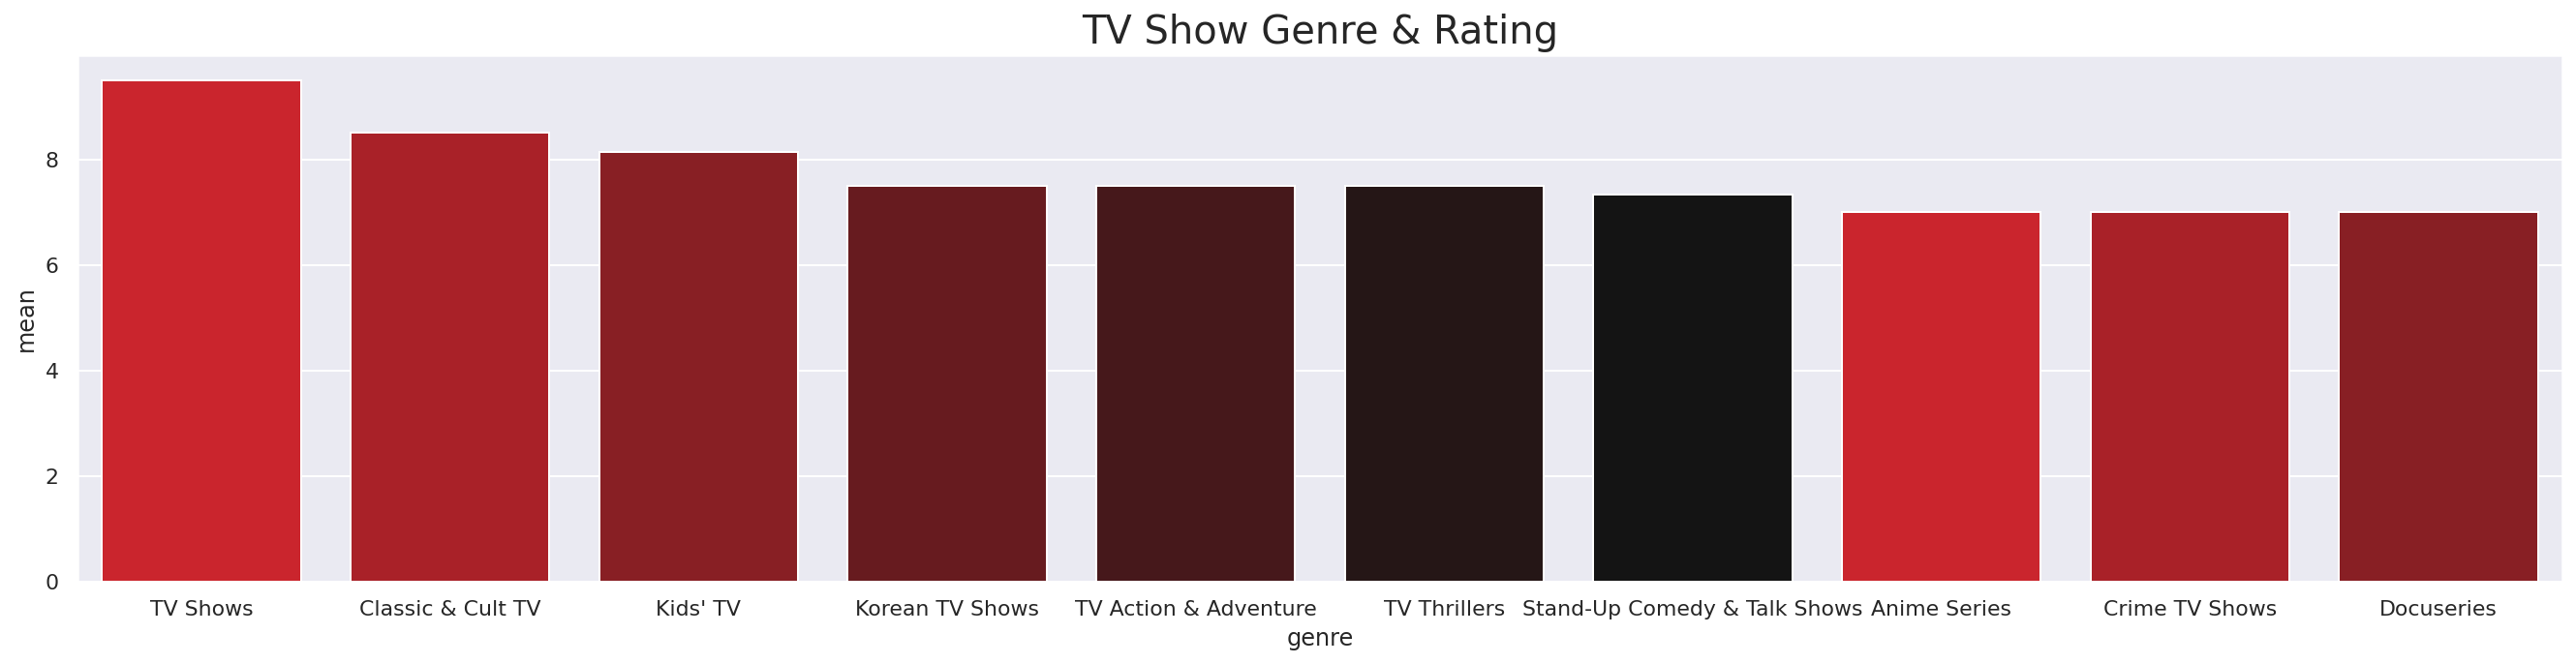

In [1311]:
plt.figure(figsize=(23,5))
plt.title('TV Show Genre & Rating', fontsize=20)
sns.barplot(data=grouped_tv.nlargest(10, 'mean'), x = "genre", y = "mean",palette = grad)
sns.set(font_scale=1)
# .nlargest(5, 'IMDB_band')

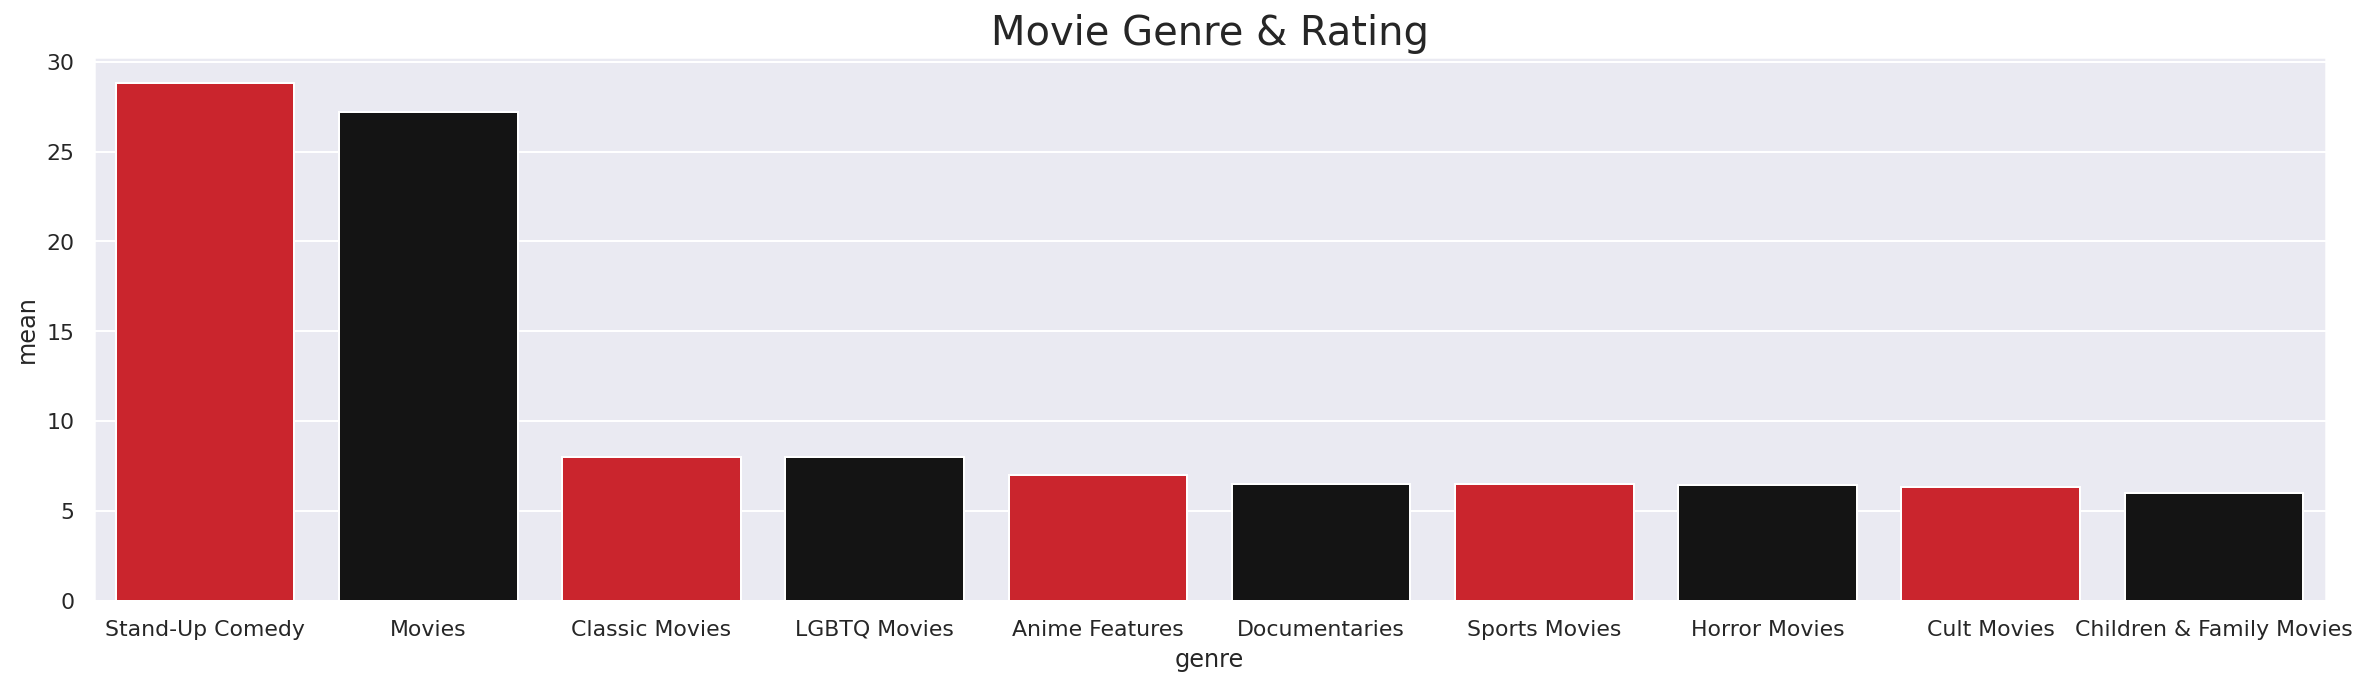

In [1313]:
plt.figure(figsize=(20,5))
#plt.ylim(8,11)
plt.title('Movie Genre & Rating', fontsize=20)
sns.barplot(data=grouped_mov.nlargest(10, 'mean'), x = "genre", y = "mean",palette = colors)
sns.set(font_scale=1)
# .nlargest(5, 'IMDB_band')

장르별 평균별점


장르별 평균별점 / 장르별 별점분포


영화 별점분포

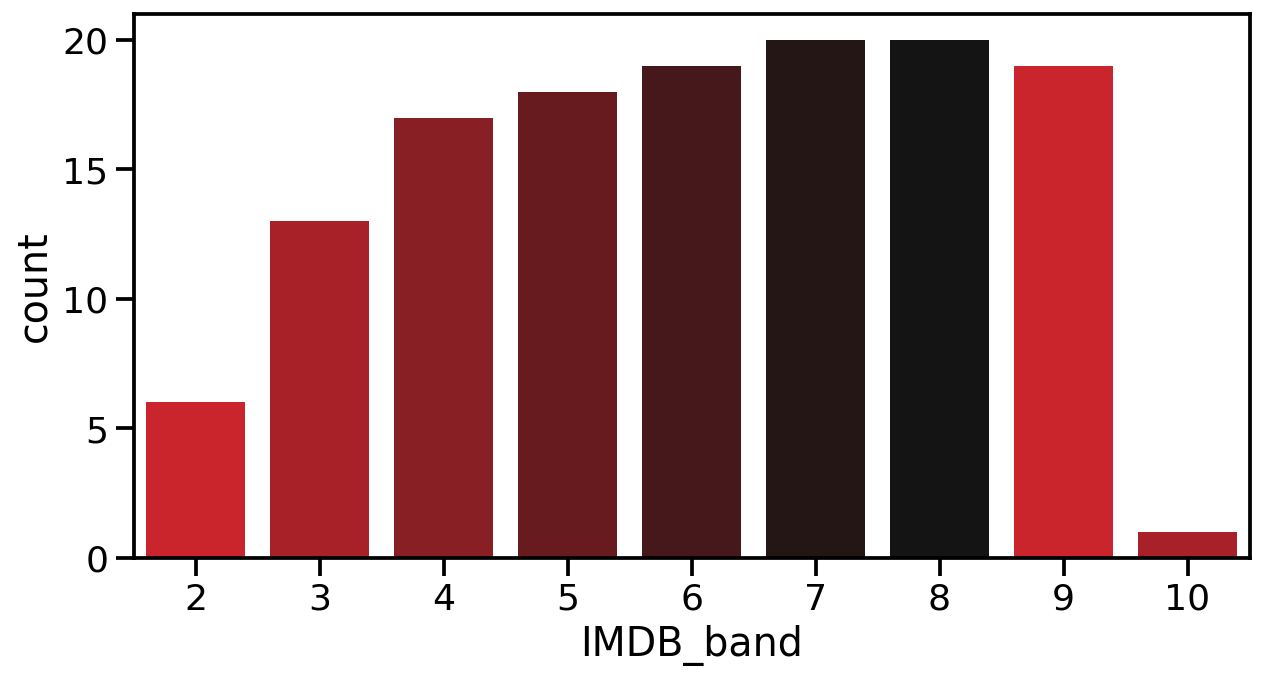

In [1285]:
plt.figure(figsize=(10,5))
sns.countplot(x='IMDB_band', data=df_movie_IMDB,palette = grad)

영화 별점분포

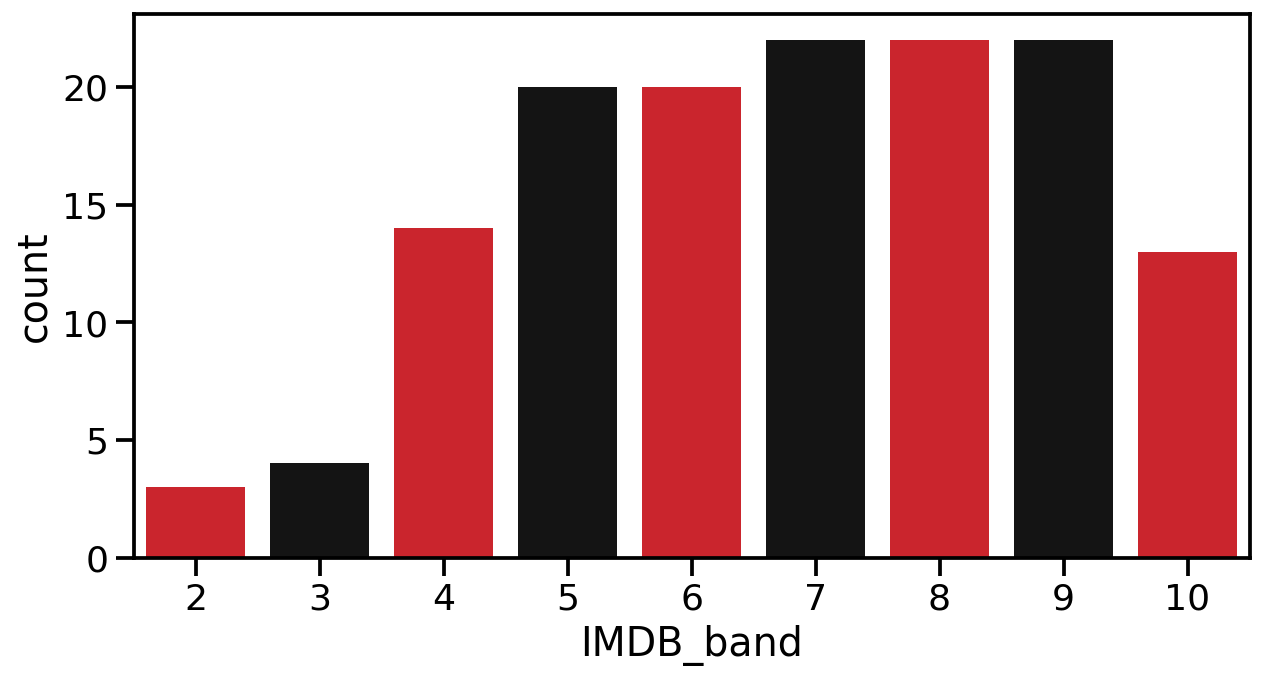

In [1286]:
plt.figure(figsize=(10,5))
sns.countplot(x='IMDB_band', data=df_tv_show_IMDB, palette = colors)

연도& 별점

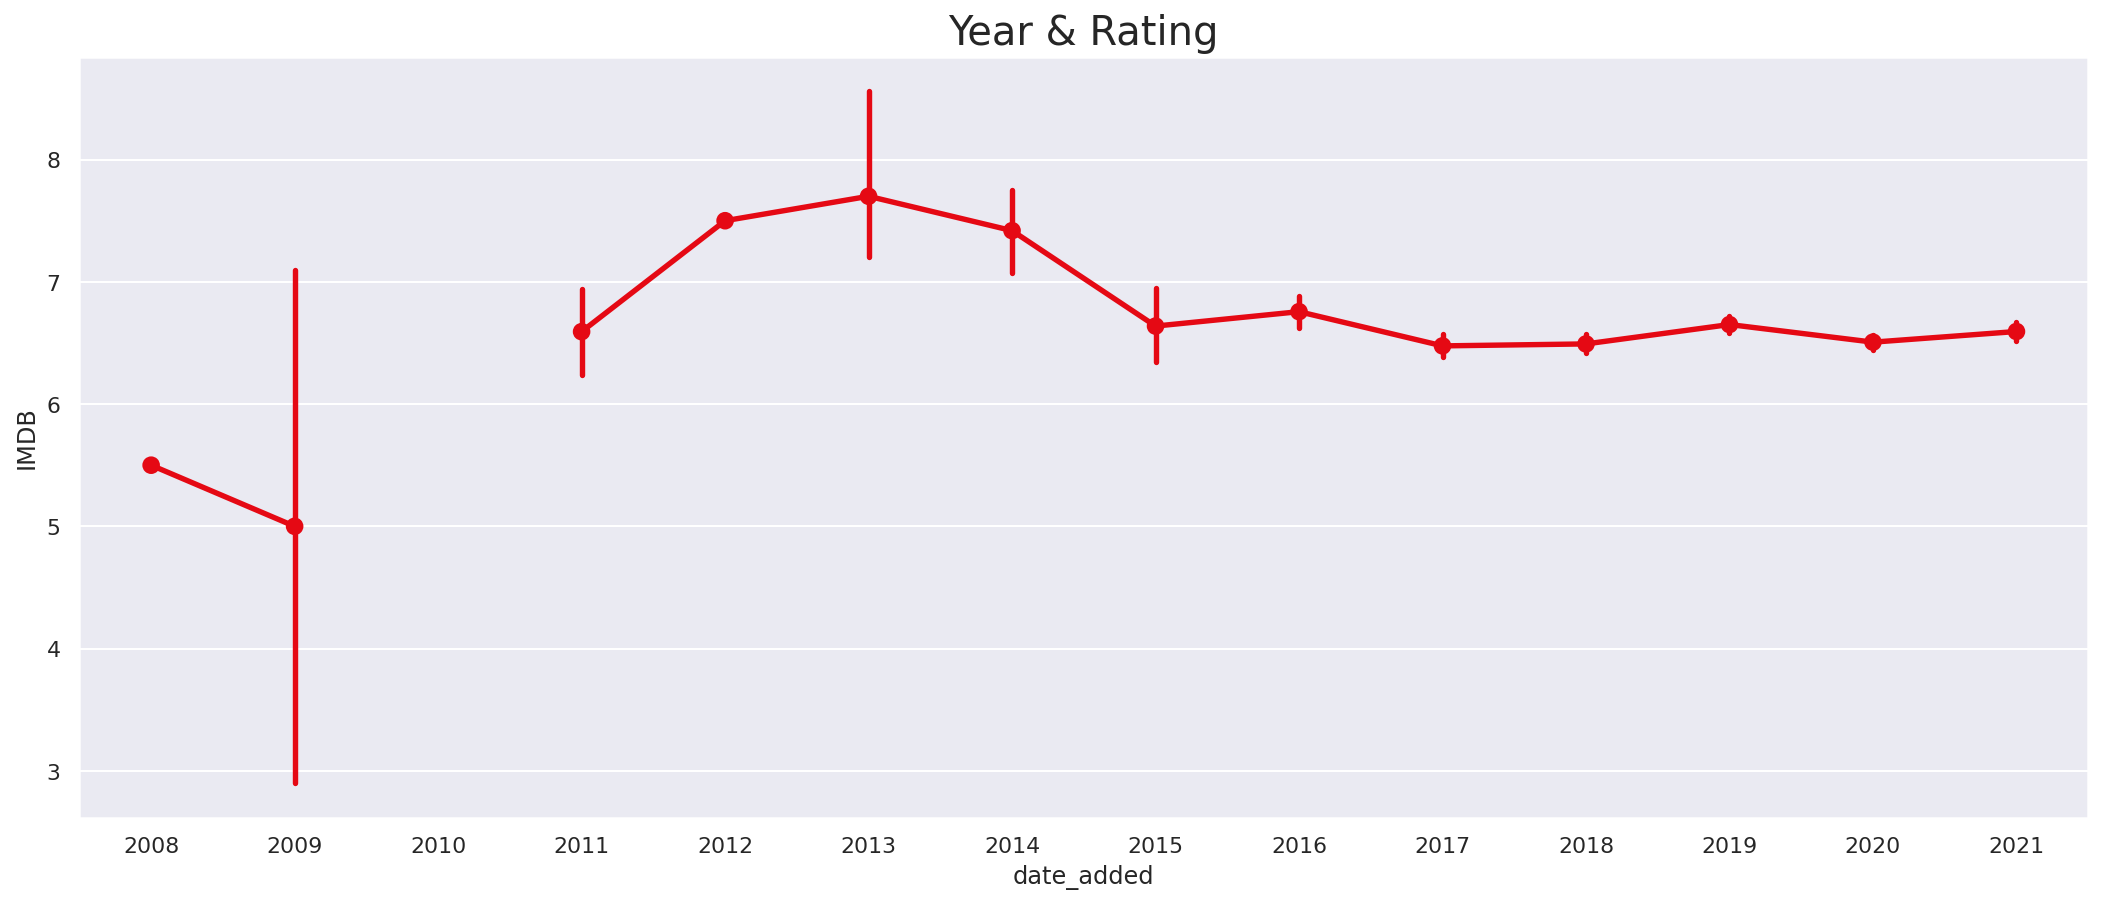

In [1328]:
fig_dims = (18,7)
fig, ax = plt.subplots(figsize=fig_dims)  
sns.pointplot(x=pd.DatetimeIndex(df_rating['date_added']).year , y='IMDB', data=df_rating)
plt.title('Year & Rating',size='20')
plt.show()


Text(0.5, 1.0, 'Year & Rating')

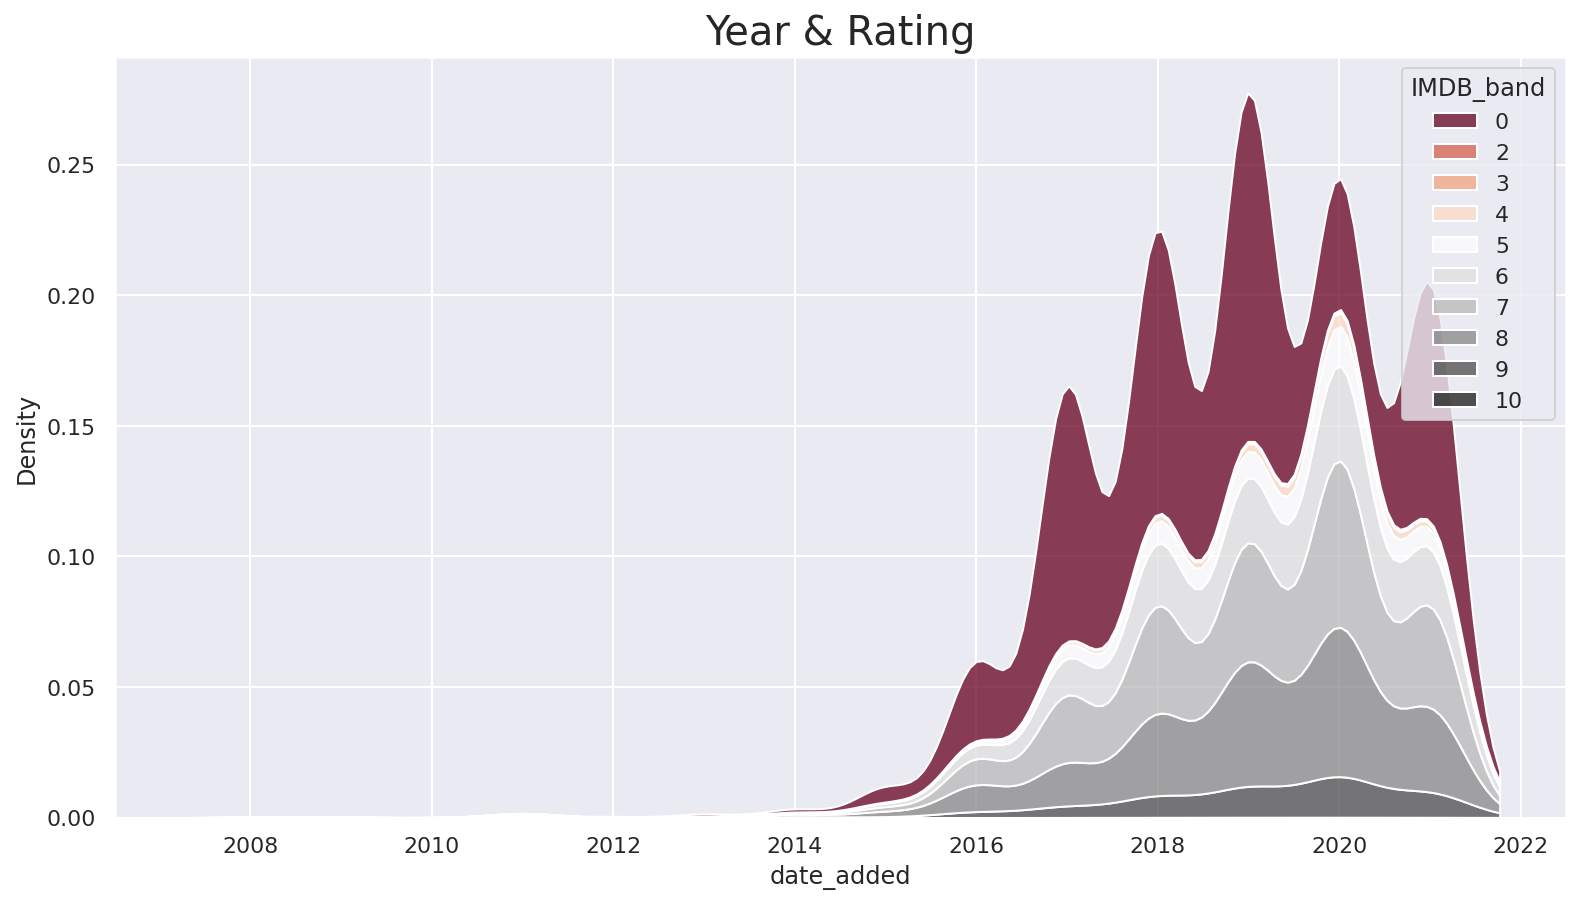

In [1332]:
plt.figure(figsize=(13,7))
sns.kdeplot(data=df_rating, x=pd.DatetimeIndex(df_rating['date_added']).year, hue = 'IMDB_band', multiple="stack", palette = 'RdGy')
plt.title('Year & Rating', fontsize=20)

참고자료

color mixer https://htmlcolors.com/color-mixer